In [10]:
from IPython.display import display, HTML

display(HTML("""
<div style="
    display: flex;
    flex-direction: column;
    justify-content: center;
    align-items: center;
    height: 90vh;
    text-align: center;
">

  <h1 style="margin-bottom: 40px;">
    NFL Win/Lose Prediction
  </h1>

  <p style="font-size: 18px; margin-bottom: 80px;">
     Regression Analysis
  </p>

  <p style="font-size: 16px; margin-bottom: 40px;">
    Nikita Jain, Charlie Peng, Yanchen Zhou
  </p>

  <p style="font-size: 16px; margin-bottom: 10px;">
    Final Project - Milestone 2
  </p>

  <p style="font-size: 16px; margin-bottom: 80px;">
    Practical Machine Learning
  </p>

  <p style="font-size: 16px;">
    February 2026
  </p>

</div>

<div style="page-break-after: always;"></div>
"""))

In [27]:
# library load
import pandas as pd
import pyarrow
import numpy as np
import nflreadpy as nfl

from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

### Data Load

Using data from nflverse's repository of NFL records, the subset of games played by the Chicago Bears is extracted.

In [40]:
pbp = nfl.load_pbp().to_pandas()
### code for reading base dataset
chi_b = nfl.load_team_stats(seasons=True).to_pandas()
chi_b = chi_b[chi_b['team']=='CHI'].copy()
chi_b = chi_b.reset_index(drop=True)

In [5]:
type(chi_b)

pandas.core.frame.DataFrame

In [6]:
chi_b.head()

,season,week,team,season_type,opponent_team,completions,attempts,passing_yards,passing_tds,passing_interceptions,...,pat_made,pat_att,pat_missed,pat_blocked,pat_pct,gwfg_made,gwfg_att,gwfg_missed,gwfg_blocked,gwfg_distance
0,1999,1,CHI,REG,KC,31,47,322,2,0,...,2,2,0,0,1.0,0,0,0,0,0
1,1999,2,CHI,REG,SEA,23,44,216,0,0,...,1,1,0,0,1.0,0,1,1,0,48
2,1999,3,CHI,REG,LV,23,35,216,2,1,...,2,2,0,0,1.0,0,0,0,0,0
3,1999,4,CHI,REG,NO,25,43,224,2,2,...,2,2,0,0,1.0,0,0,0,0,0
4,1999,5,CHI,REG,MIN,28,42,281,2,0,...,3,3,0,0,1.0,0,0,0,0,0


# Executive Summary

The focus of this project is to construct a regression model predicting win/loss for National Football League games played by the Chicago Bears, based on the attributes of a particular game. Using game datasets from popular NFL data repository nflverse, a regression model can be constructed using metrics like number of points scored, number of interceptions, points given away from turnovers, etc. 

Utilizing methods like logistic regression, Random Forest, and decision trees - among other methods - game outcomes will be modeled based on the available historical data and tested on a subset of seasonal game records.

# Problem Statement/Research objective

Given a set of historical descriptive statistics for National Football League games, including points scored, winning team, yards per game, etc., can a model be trained to predict game outcomes with high accuracy?

# Exploratory Data Analysis

The dataset we will be using comprises of NFL game data on games played by the Chicago Bears from 1999-present day. Each year comprises of one season of games, which is split into 2 main categories - 

**Regular Season** - 18 weeks of games played by all teams within their conferences

**Post Season/Playoffs** - The best performers in the regular season go on to compete in brackets, and the last team standing is the winner of the Super Bowl

The below dataset contains all games recorded for the Chicago Bears for both the regular and post-season periods, and has 448 rows and 102 columns - each row corresponds to a game played. 

In [8]:
chi_b.shape

(448, 102)

Below, we can look at some summary statistics for the columns:

In [9]:
chi_b.describe()

,season,week,completions,attempts,passing_yards,passing_tds,passing_interceptions,sacks_suffered,sack_yards_lost,sack_fumbles,...,pat_made,pat_att,pat_missed,pat_blocked,pat_pct,gwfg_made,gwfg_att,gwfg_missed,gwfg_blocked,gwfg_distance
count,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,...,448.000000,448.000000,448.000000,448.000000,398.000000,448.000000,448.000000,448.000000,448.000000,448.000000
mean,2012.122768,9.430804,19.607143,32.823661,214.479911,1.263393,1.029018,2.482143,-16.263393,0.397321,...,2.002232,2.055804,0.035714,0.017857,0.975000,0.053571,0.064732,0.006696,0.004464,2.604911
std,7.849286,5.231092,6.068007,8.434385,73.017050,1.050109,1.101781,1.754417,12.925264,0.589386,...,1.323508,1.334120,0.208481,0.132580,0.114916,0.225422,0.246328,0.081648,0.066741,10.252851
min,1999.000000,1.000000,4.000000,7.000000,34.000000,0.000000,0.000000,0.000000,-67.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005.000000,5.000000,15.000000,27.000000,157.000000,0.000000,0.000000,1.000000,-23.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2012.000000,10.000000,19.000000,32.000000,212.000000,1.000000,1.000000,2.000000,-13.000000,0.000000,...,2.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2019.000000,14.000000,24.000000,38.000000,262.250000,2.000000,2.000000,3.000000,-7.000000,1.000000,...,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2025.000000,21.000000,36.000000,63.000000,422.000000,6.000000,5.000000,10.000000,0.000000,3.000000,...,6.000000,6.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,65.000000


The 'season' variable aligns with the year in which the game was played. As we can see, the earliest recorded season in the dataset is from 1999, going on up until 2025.

In [18]:
print("Object columns: ")
chi_b.dtypes[chi_b.dtypes == 'object']

team               object
season_type        object
opponent_team      object
fg_made_list       object
fg_missed_list     object
fg_blocked_list    object
dtype: object

Since the team present in the dataset will only be the Chicago Bears, we can remove this column eventually. For the purpose of this project, there will not be a difference between season_type = regular or post-season, so we can also eliminate this column. 

In [23]:
print("Numeric columns: ")
chi_b.dtypes[(chi_b.dtypes == 'float64')]

Numeric columns: 


passing_epa       float64
passing_cpoe      float64
rushing_epa       float64
receiving_epa     float64
def_sacks         float64
def_sack_yards    float64
fg_long           float64
fg_pct            float64
pat_pct           float64
dtype: object

In [24]:
chi_b.dtypes[(chi_b.dtypes == 'int32')]

season           int32
week             int32
completions      int32
attempts         int32
passing_yards    int32
                 ...  
gwfg_made        int32
gwfg_att         int32
gwfg_missed      int32
gwfg_blocked     int32
gwfg_distance    int32
Length: 87, dtype: object

### Missing values

Missing values can be checked for quantity:

In [29]:
# check NaNs across columns
null_cols = pd.DataFrame(chi_b.isnull().sum().sort_values(ascending=False), columns=['count'])
null_cols = null_cols[null_cols['count']>0]
null_cols['PerOfTotal'] = round(null_cols['count']*100/len(chi_b), 2)
null_cols['VarName'] = null_cols.index
null_cols['VarType'] = null_cols['VarName'].apply(lambda x: chi_b.dtypes[x])
null_cols = null_cols.drop(columns='VarName')

print(tabulate(null_cols, headers='keys', tablefmt='psql'))

+-----------------+---------+--------------+-----------+
|                 |   count |   PerOfTotal | VarType   |
|-----------------+---------+--------------+-----------|
| fg_blocked_list |     424 |        94.64 | object    |
| fg_missed_list  |     337 |        75.22 | object    |
| passing_cpoe    |     114 |        25.45 | float64   |
| fg_made_list    |      97 |        21.65 | object    |
| fg_long         |      97 |        21.65 | float64   |
| fg_pct          |      63 |        14.06 | float64   |
| pat_pct         |      50 |        11.16 | float64   |
+-----------------+---------+--------------+-----------+


There are two columns with all null data: fg_blocked_list and fg_missed_list. From the data dictionary, both of these are supposed to contain information about the distance from which any field goals during the game were blocked or missed. These columns are null due to no blocked or missed field goals during the vast majority of the games - this aligns with expectations, as a field goal being missed or blocked is a rare occurence. These columns can be dropped as field goal information is also available in other columns.

fg_made_list has nulls for the same reason - any games without any field goals made would present nulls in those records. We also already have the information of field goals made in another column, so this column can be dropped as well. The other fg (field goal) type columns present nulls for the same.

From the data dictionary, pat_pct records the percentage of extra point kicks successfully completed. For games without any extra point kicks, this field would be null - we can replace nulls with 0s. passing_cpoe shows nulls due to the metric being relatively new, and not officially calculated for older games.

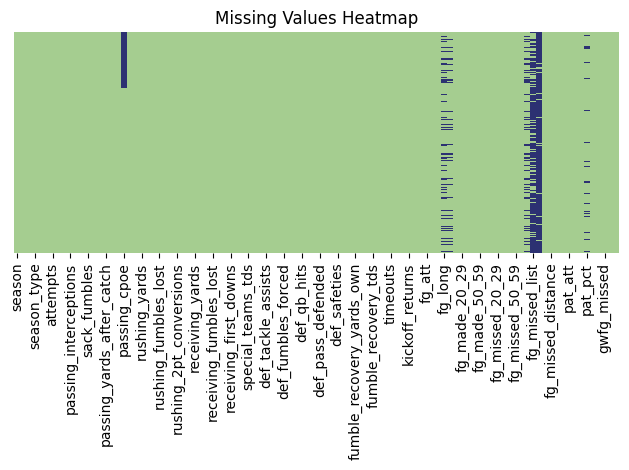

In [30]:
heatmap_df = chi_b.copy()
for col in heatmap_df.select_dtypes(include=["object", "category"]).columns:
    heatmap_df[col] = heatmap_df[col].astype("category").cat.codes
    heatmap_df[col] = heatmap_df[col].replace(-1, np.nan)

sns.heatmap(heatmap_df.isnull(), cbar=False, cmap="crest", yticklabels=False)
plt.title("Missing Values Heatmap")
plt.tight_layout()
plt.show()

The above heatmap visualizes the information presented in the table previously. 

### Negative Values

We can check for negative values present in the dataset below:

In [31]:
num_cols = chi_b.select_dtypes(include=["int32","int64","float64","Int64"]).columns

neg_counts = ((chi_b[num_cols] < 0) & (chi_b[num_cols] != -1)).sum().sort_values(ascending=False)
neg_counts = neg_counts[neg_counts > 0]
neg_counts

sack_yards_lost           402
rushing_epa               295
passing_epa               266
passing_cpoe              173
receiving_epa             135
punt_return_yards          10
def_interception_yards      5
dtype: int64

From the data dictionary, all of these columns have negative values for a reason. sack_yards_lost, punt_return_yards and def_interception_yards are all directional - when a team loses yards due to sacks or interceptions, it counts as a negative against their record and a positive for the opposing team's record.

rushing_epa, passing_epa, passing_cpoe, and receiving_epa are all newer, advanced metrics measuring the impact of a rushing, passing or recieving play on the expected points to be gained by the team. If the rushing, passing or receiving play leads to a loss of points, the expected points impact is negative - leading to the above negative values.

For the purposes of our model, if negative values cannot be tolerated, an absolute value can be taken as the correlation will remain the same, just flipped to negative.

### Feature Analysis

We can construct a quick correlation matrix for the numeric variables present, and look at some distributions:

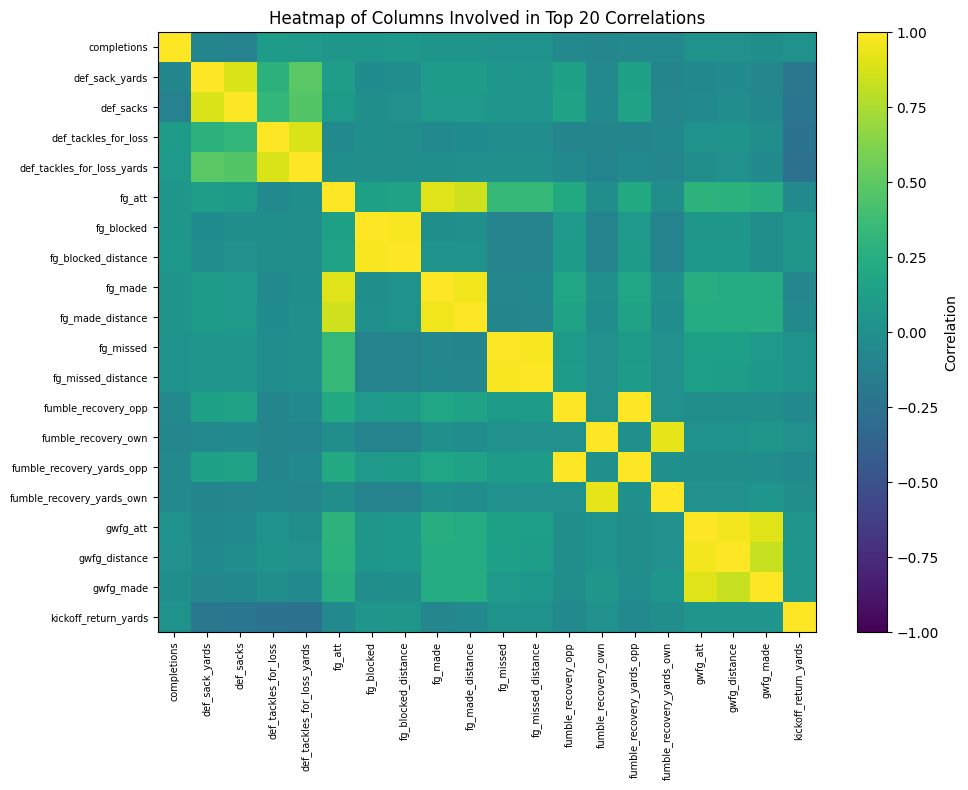

passing_first_downs      receiving_first_downs         1.000000
passing_2pt_conversions  receiving_2pt_conversions     1.000000
passing_tds              receiving_tds                 1.000000
passing_air_yards        receiving_air_yards           1.000000
completions              receptions                    1.000000
passing_yards            receiving_yards               1.000000
fumble_recovery_opp      fumble_recovery_yards_opp     0.995583
fg_missed                fg_missed_distance            0.984341
pat_made                 pat_att                       0.983109
fg_blocked               fg_blocked_distance           0.978980
gwfg_att                 gwfg_distance                 0.966811
fg_made                  fg_made_distance              0.958299
fumble_recovery_own      fumble_recovery_yards_own     0.923813
gwfg_made                gwfg_att                      0.904338
fg_made                  fg_att                        0.899502
sacks_suffered           sack_yards_lost

In [33]:
corr = chi_b.corr(numeric_only=True)

pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .sort_values(key=lambda s: s.abs(), ascending=False)
)

top_k_pairs = 20  
top_pairs = pairs.head(top_k_pairs)

top_cols = sorted(set([i for i, j in top_pairs.index] + [j for i, j in top_pairs.index]))

max_cols = 20
top_cols = top_cols[:max_cols]

subcorr = corr.loc[top_cols, top_cols]

plt.figure(figsize=(10, 8))
plt.imshow(subcorr, aspect="auto", vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.title(f"Heatmap of Columns Involved in Top {top_k_pairs} Correlations")

plt.xticks(range(len(top_cols)), top_cols, rotation=90, fontsize=7)
plt.yticks(range(len(top_cols)), top_cols, fontsize=7)

plt.tight_layout()
plt.show()

top_pairs

The top 20 most correlated pairs of features are shown above. For models where collinearity and inter-correlation is an issue, pairs that are highly correlated should be removed. Additionally, any features that are linearly dependent should be removed for all models.

### Target Variable - Feature Creation

The game results for each game are provided through the same repository, and can be shown below:

In [52]:
chi_game_results = nfl.load_schedules().to_pandas()
chi_win_stats = chi_game_results[(chi_game_results['away_team']=="CHI") | (chi_game_results['home_team']=="CHI")]
chi_win_stats[['season','week','away_team','home_team','result']].head()

,season,week,away_team,home_team,result
1,1999,1,KC,CHI,3.0
18,1999,2,SEA,CHI,-1.0
38,1999,3,CHI,OAK,7.0
45,1999,4,NO,CHI,4.0
65,1999,5,CHI,MIN,-2.0


The result column has positive or negative values depending on the result of the game. The magnitude shows the point differential between the points made by the two teams. When the result is negative, the game was lost by the home team and won by the away team. When the result is positive, the game was won by the home team and lost by the away team. This calculation can be easily done to get a binary win (1) lose (0) target variable for each game, or the original result can be kept if a non-binary prediction model is used.